In [1]:

import os,sys
root_dir=os.path.abspath(os.path.join(os.getcwd(),'..'))
sys.path.append(root_dir)

import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

from models.utils.discriminativ_loss import combined_loss
from models.FCN import ResNet,BasicBlock
from data.FER2013 import FER2013
from data.utils import merger,augmentations

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tf

Initalizing FER2013 dataset for train split
Emotion classes: ['happy', 'surprise', 'sad', 'angry', 'disgust', 'fear']
Number of images in each class: {'happy': 7215, 'surprise': 3171, 'sad': 4830, 'angry': 3995, 'disgust': 436, 'fear': 4097}
Total number of images: 23744
Total size of dataset: 0.03 GB
Loading images from happy class


100%|██████████| 7215/7215 [00:03<00:00, 1970.85it/s]


Loading images from surprise class


100%|██████████| 3171/3171 [00:01<00:00, 1885.05it/s]


Loading images from sad class


100%|██████████| 4830/4830 [00:02<00:00, 2108.19it/s]


Loading images from angry class


100%|██████████| 3995/3995 [00:01<00:00, 2135.72it/s]


Loading images from disgust class


100%|██████████| 436/436 [00:00<00:00, 1762.07it/s]


Loading images from fear class


100%|██████████| 4097/4097 [00:01<00:00, 2061.13it/s]


Initalizing FER2013 dataset for test split
Emotion classes: ['happy', 'surprise', 'sad', 'angry', 'disgust', 'fear']
Number of images in each class: {'happy': 1774, 'surprise': 831, 'sad': 1247, 'angry': 958, 'disgust': 111, 'fear': 1024}
Total number of images: 5945
Total size of dataset: 0.01 GB
Loading images from happy class


100%|██████████| 1774/1774 [00:00<00:00, 3614.83it/s]


Loading images from surprise class


100%|██████████| 831/831 [00:00<00:00, 3591.07it/s]


Loading images from sad class


100%|██████████| 1247/1247 [00:00<00:00, 3592.54it/s]


Loading images from angry class


100%|██████████| 958/958 [00:00<00:00, 3437.30it/s]


Loading images from disgust class


100%|██████████| 111/111 [00:00<00:00, 3509.22it/s]


Loading images from fear class


100%|██████████| 1024/1024 [00:00<00:00, 3545.64it/s]


torch.Size([16, 1, 64, 64]) torch.Size([16, 6])


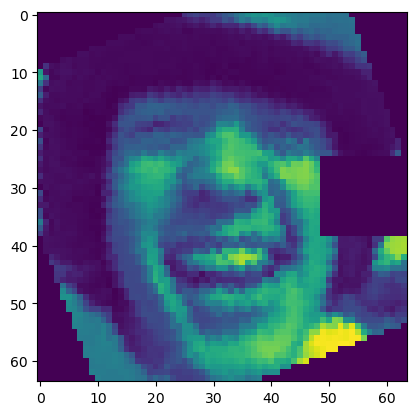

In [2]:
train_transform = tf.Compose(
    [
        tf.Resize((64, 64)),
        tf.Grayscale(),
        tf.RandomHorizontalFlip(p=0.5),
        tf.RandomRotation(degrees=25),
        tf.ToTensor(),
        #tf.Lambda(lambda x: x.repeat(3, 1, 1)),
        tf.RandomErasing(0.5, scale=(0.02, 0.08), ratio=(0.3, 3.0)),
    ]
)
test_transform = tf.Compose(
    [
        tf.Resize((64, 64)),
        tf.Grayscale(),
        tf.ToTensor(),
        #tf.Lambda(lambda x: x.repeat(3, 1, 1)),
    ]
)
traindataset = FER2013(transform=train_transform, split="train")
testdataset = FER2013(transform=test_transform, split="test")
traindataloader, testdataloader = DataLoader(
    traindataset, batch_size=16, shuffle=True
), DataLoader(testdataset, batch_size=16, shuffle=False)

# test the dataloader
for i, (data, label) in enumerate(traindataloader):
    print(data.shape, label.shape)
    plt.imshow(data[0].permute(1, 2, 0))
    break

In [3]:
# initialize the tensorboard and log dir
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("logs/ResNet18")

2025-01-07 17:52:24.941911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-07 17:52:24.951161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-07 17:52:24.953733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 17:52:24.962171: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# using resne18 from torchvision
from torchvision.models import resnet18
model = resnet18()
model.fc = nn.Linear(512,6)
model = model.cuda()

# using vit from torchvision
# import torchvision
# model = torchvision.models.vit_b_16()
# model.head = nn.Linear(768,6)
# model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)

def train(model,dataloader,criterion,optimizer):
    model.train()
    running_loss = 0
    running_corrects = 0
    for i,(data,label) in enumerate(tqdm(dataloader)):
        data,label = data.cuda(),label.cuda()
        optimizer.zero_grad()
        # resize image to 224x224
        data = nn.functional.interpolate(data,size=(224,224))
        #duplicate from 1 channel to 3 channel
        data = data.repeat(1,3,1,1)
        
        output = model(data)
        loss = criterion(output, torch.argmax(label, dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(torch.argmax(output,dim=1)==torch.argmax(label, dim=1)).item()
    return running_loss/len(dataloader),running_corrects/len(dataloader.dataset)

def test(model,dataloader,criterion):
    model.eval()
    running_loss = 0
    running_corrects = 0
    with torch.no_grad():
        for i,(data,label) in enumerate(tqdm(dataloader)):
            data,label = data.cuda(),label.cuda()
            # resize image to 224x224
            data = nn.functional.interpolate(data,size=(224,224))
            #duplicate from 1 channel to 3 channel
            data = data.repeat(1,3,1,1)
            output = model(data)
            loss = criterion(output, torch.argmax(label, dim=1))
            running_loss += loss.item()
            running_corrects += torch.sum(torch.argmax(output,dim=1)==torch.argmax(label,dim=1)).item()
    return running_loss/len(dataloader),running_corrects/len(dataloader.dataset)

def train_model(model,traindataloader,testdataloader,criterion,optimizer,num_epochs=10):
    for epoch in range(num_epochs):
        train_loss,train_acc = train(model,traindataloader,criterion,optimizer)
        writer.add_scalar('train_loss',train_loss,epoch)
        writer.add_scalar('train_acc',train_acc,epoch)
        
        test_loss,test_acc = test(model,testdataloader,criterion)
        writer.add_scalar('test_loss',test_loss,epoch)
        writer.add_scalar('test_acc',test_acc,epoch)
        
        print(f'epoch:{epoch} train_loss:{train_loss:.2f} train_acc:{train_acc:.2%} test_loss:{test_loss:.2f} test_acc:{test_acc:.2%}')
train_model(model,traindataloader,testdataloader,criterion,optimizer,num_epochs=10)

/tmp/ipykernel_571647/3304563802.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(data,label) in enumerate(tqdm(dataloader)):


  0%|          | 0/1484 [00:00<?, ?it/s]

/root/miniconda3/envs/rapids-21.12/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/tmp/ipykernel_571647/3304563802.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(data,label) in enumerate(tqdm(dataloader)):


  0%|          | 0/372 [00:00<?, ?it/s]

epoch:0 train_loss:1.64 train_acc:29.17% test_loss:1.97 test_acc:27.96%


  0%|          | 0/1484 [00:00<?, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]

epoch:1 train_loss:1.54 train_acc:36.18% test_loss:1.39 test_acc:43.99%


  0%|          | 0/1484 [00:00<?, ?it/s]

  0%|          | 0/372 [00:00<?, ?it/s]

epoch:2 train_loss:1.36 train_acc:44.65% test_loss:1.59 test_acc:43.41%


  0%|          | 0/1484 [00:00<?, ?it/s]

KeyboardInterrupt: 